In [1]:
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader,random_split
from torchvision import datasets
from torchvision.transforms import *
import matplotlib.pyplot as plt
import torchvision
import os
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,Model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import os
from PIL import Image
import numpy as np

class BSDS500:
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.Training_image_paths = [] 
        self.testing_image_paths =  []
        
        for sub_dir in os.listdir(root_dir):         
            if(sub_dir == 'train'):
                for training_image_path in os.listdir(os.path.join(root_dir, sub_dir)):
                    if training_image_path.endswith(('.png', '.jpg', '.jpeg')):
                        self.Training_image_paths.append(os.path.join(root_dir, sub_dir, training_image_path))
            elif(sub_dir == 'test'):
                for test_image_path in os.listdir(os.path.join(root_dir, sub_dir)):
                    if test_image_path.endswith(('.png', '.jpg', '.jpeg')):
                        self.testing_image_paths.append(os.path.join(root_dir, sub_dir, test_image_path))
        
    def __len__(self):
        return len(self.Training_image_paths)

    def __getitem__(self, idx):
        img_name = self.Training_image_paths[idx]
        image = Image.open(img_name)

        # Use PIL's resize function instead of cv2.resize
        image = image.resize((256, 256))

        # Convert the image to a numpy array
        image = np.array(image)

        sample = {'image': image}
        return sample
    
    def get_images(self):
        training_images = []
        testing_images = []
        for path in self.Training_image_paths:
            image = Image.open(path)
            # Use PIL's resize function instead of cv2.resize
            image = image.resize((256, 256))
            # Convert the image to a numpy array
            image = np.array(image)
            training_images.append(image)
        for path in self.testing_image_paths:
            image = Image.open(path)
            # Use PIL's resize function instead of cv2.resize
            image = image.resize((256, 256))
            # Convert the image to a numpy array
            image = np.array(image)
            testing_images.append(image)
        return np.array(training_images), np.array(testing_images)


In [3]:
data_gen = BSDS500('/kaggle/input/berkeley-segmentation-dataset-500-bsds500/images', )
x_train, x_test = data_gen.get_images()
x_train = x_train/255.
x_test = x_test /255.
x_train

array([[[[0.45490196, 0.57254902, 0.66666667],
         [0.45098039, 0.56862745, 0.6627451 ],
         [0.44705882, 0.56470588, 0.65882353],
         ...,
         [0.6745098 , 0.76862745, 0.88627451],
         [0.67843137, 0.76862745, 0.89019608],
         [0.67843137, 0.76862745, 0.89019608]],

        [[0.4627451 , 0.58039216, 0.6745098 ],
         [0.46666667, 0.58431373, 0.67843137],
         [0.46666667, 0.58431373, 0.67843137],
         ...,
         [0.66666667, 0.76470588, 0.88235294],
         [0.66666667, 0.76470588, 0.88235294],
         [0.65882353, 0.75294118, 0.87058824]],

        [[0.47058824, 0.58039216, 0.6745098 ],
         [0.47843137, 0.58823529, 0.68235294],
         [0.47843137, 0.59215686, 0.68235294],
         ...,
         [0.63137255, 0.72941176, 0.84705882],
         [0.64313725, 0.74117647, 0.85882353],
         [0.64313725, 0.7372549 , 0.85490196]],

        ...,

        [[0.53333333, 0.50196078, 0.45490196],
         [0.53333333, 0.50588235, 0.45490196]

In [4]:
x_train[0].shape

(256, 256, 3)

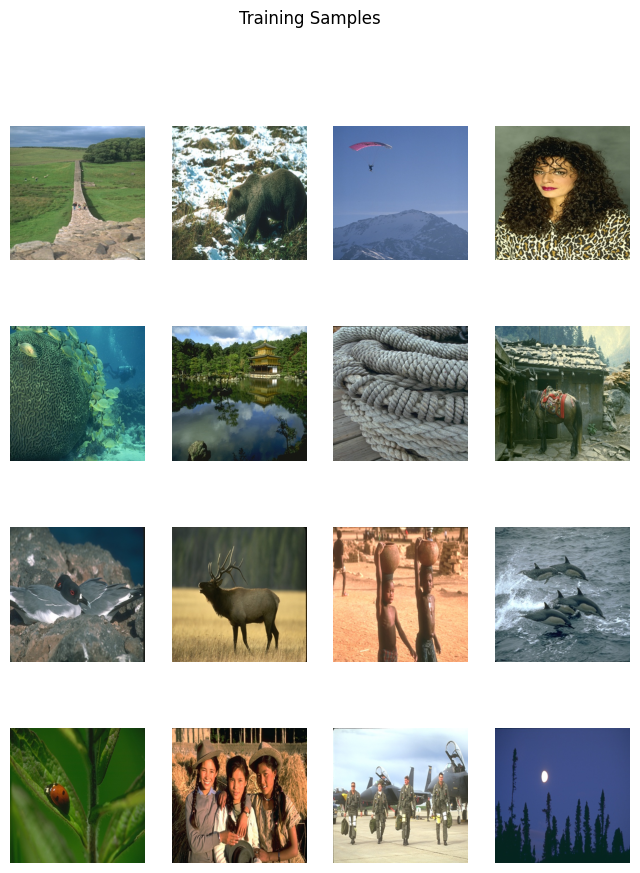

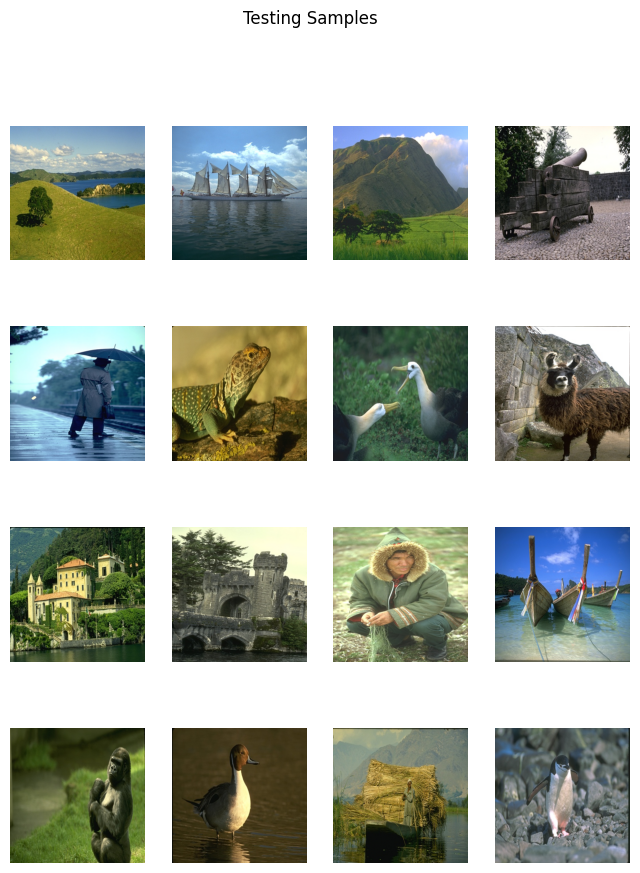

In [5]:
import matplotlib.pyplot as plt
def display_images(images, title):
    n = len(images)
    sqrt_n = int(np.ceil(np.sqrt(n)))
    fig, axes = plt.subplots(sqrt_n, sqrt_n, figsize=(8, 10))

    for i in range(sqrt_n**2):
        ax = axes[i // sqrt_n, i % sqrt_n]
        if i < n:
            ax.imshow(images[i], cmap='gray')
            ax.axis('off')
        else:
            ax.remove()

    plt.suptitle(title)
    plt.show()

# Display some training samples
display_images(x_train[:16], 'Training Samples')

# Display some testing samples
display_images(x_test[:16], 'Testing Samples')

In [6]:
def Gaussin_noise(images, mean=0, std=0.5):
    noised_images = []
    for img in images:
        noise = np.random.normal(mean, std, img.shape)  # Generate noise with the same shape as the image
        img = img + noise
        noised_images.append(img )  # Normalize the image to the range [0, 1]
    return np.stack(noised_images )
x_train_noised=Gaussin_noise(x_train)
x_test_noised=Gaussin_noise(x_test)


In [7]:
x_train_noised.shape
x_train.shape
x_train_noised_flatten=x_train_noised.reshape(x_train_noised.shape[0],256*256*3)
x_test_noised_flatten=x_test_noised.reshape(x_test_noised.shape[0],256*256*3)
x_train_flatten=x_train.reshape(x_train.shape[0],256*256*3)
x_test_flatten=x_test.reshape(x_test.shape[0],256*256*3)

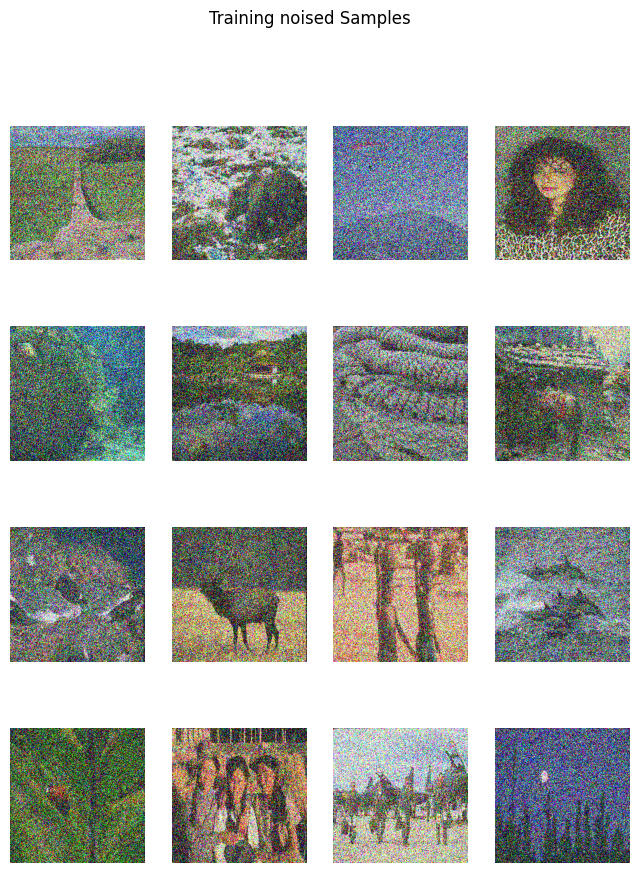

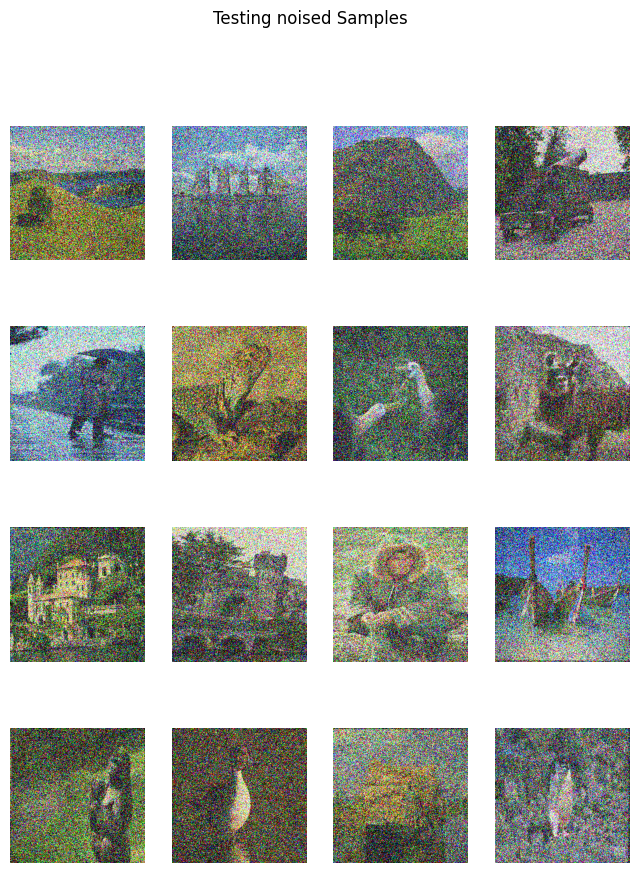

In [8]:
display_images(x_train_noised[:16], 'Training noised Samples')

# Display some testing samples
display_images(x_test_noised[:16], 'Testing noised Samples')

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Encoder
input_img = tf.keras.Input(shape=(256 * 256 * 3,))
x = layers.Dense(512, activation='relu')(input_img)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1(0.01))(x)
x = layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l1(0.01))(x)
encoded = layers.Dense(112, activation='relu')(x)

# Decoder
x = layers.Dense(64, activation='relu')(encoded)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l1(0.01))(x)
x = layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l1(0.01))(x)
decoded = layers.Dense(256 * 256 * 3, activation='sigmoid')(x)

autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)

# Separate decoder model
encoded_input = tf.keras.Input(shape=(112,))
decoder_layer = autoencoder.layers[-5](encoded_input)
decoder_layer = autoencoder.layers[-4](decoder_layer)
decoder_layer = autoencoder.layers[-3](decoder_layer)
decoder_layer = autoencoder.layers[-2](decoder_layer)
decoder_layer = autoencoder.layers[-1](decoder_layer)
decoder = Model(encoded_input, decoder_layer) 

# Print model summaries
autoencoder.summary()
encoder.summary()
decoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 196608)]          0         
                                                                 
 dense (Dense)               (None, 512)               100663808 
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 112)               7280      
                                                                 
 dense_5 (Dense)             (None, 64)                7232  

In [15]:
# autoencoder.compile(optimizer='adam', loss='mse')

# x_train_noised_flattened = x_train_noised.reshape(x_train.shape[0], -1)
# x_test_noised_flattened = x_test_noised.reshape(x_train_noised.shape[0], -1)
# x_train_flatten=x_train.reshape(x_train.shape[0], -1)

# # Assuming x_train and x_train_noised have shapes (num_samples, 256, 256, 3)
# history=autoencoder.fit(x_train_flatten,x_train_noised_flattened,
#                 epochs=50,
#                 batch_size=100,
#                 validation_split=0.2)  # Use validation_split instead of validation_data
from tensorflow.keras import regularizers
# Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model.fit(x_train, y_train, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/50
2/2 [==============================] - 4s 433ms/step - loss: 0.2908 - val_loss: 0.2975
Epoch 2/50
2/2 [==============================] - 0s 131ms/step - loss: 0.2894 - val_loss: 0.2978
Epoch 3/50
2/2 [==============================] - 0s 126ms/step - loss: 0.2887 - val_loss: 0.2984
Epoch 4/50
2/2 [==============================] - 0s 127ms/step - loss: 0.2879 - val_loss: 0.2985
Epoch 5/50
2/2 [==============================] - 0s 149ms/step - loss: 0.2873 - val_loss: 0.2984
Epoch 6/50
2/2 [==============================] - 0s 126ms/step - loss: 0.2867 - val_loss: 0.2983
Epoch 7/50
2/2 [==============================] - 0s 133ms/step - loss: 0.2866 - val_loss: 0.2980
Epoch 8/50
2/2 [==============================] - 0s 134ms/step - loss: 0.2862 - val_loss: 0.2982
Epoch 9/50
2/2 [==============================] - 0s 126ms/step - loss: 0.2859 - val_loss: 0.2981
Epoch 10/50
2/2 [==============================] - 0s 145ms/step - loss: 0.2857 - val_loss: 0.2980
Epoch 11/50
2/2 [==

7/7 [==============================] - 0s 2ms/step


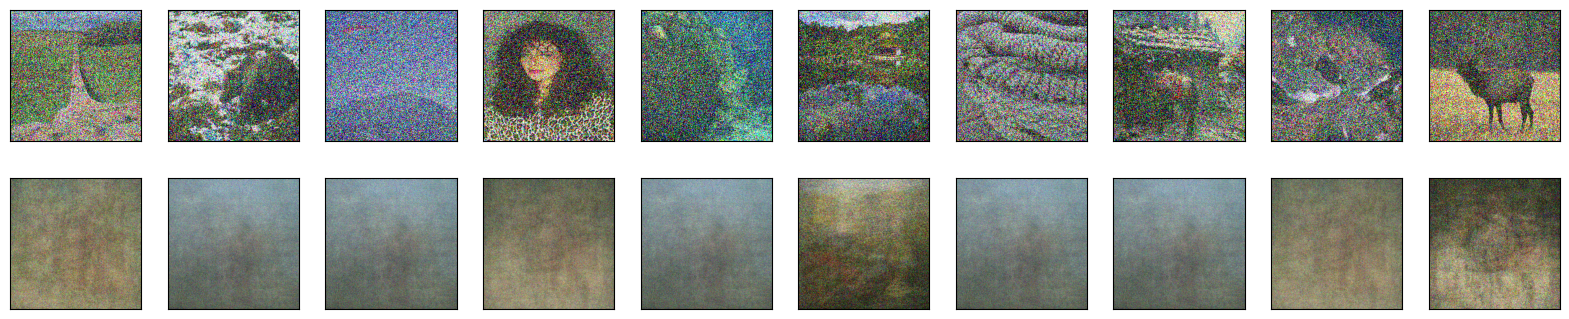

In [16]:
training_latten=encoder.predict(x_train_noised_flattened)
training_decoded=decoder.predict(training_latten)
plot_images(x_train_noised,training_decoded)

7/7 [==============================] - 0s 2ms/step


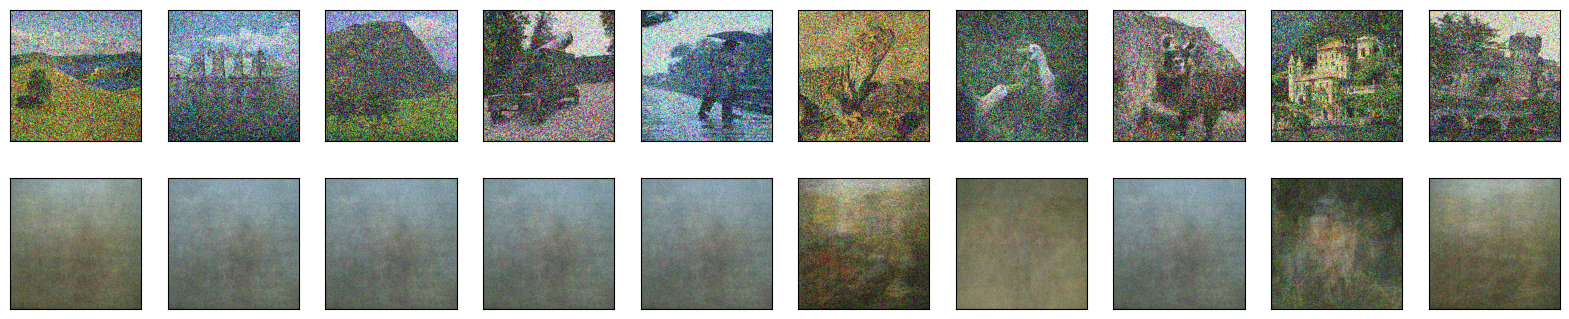

In [17]:
latten=encoder.predict(x_test_noised_flattened )
decoded=decoder.predict(latten)
plot_images(x_test_noised ,decoded)

In [18]:
def plot_images(noised_images,decoded_images):
    
    n = 10  # How many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(noised_images[i].reshape(256, 256, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_images[i].reshape(256, 256, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()





Auto Encoder Using CNN

In [36]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = (256, 256, 3)

#like Unet but Without Skip Connections

# Encoder
cnn_encoder_input = tf.keras.Input(shape=input_shape, name='encoder_input')
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(cnn_encoder_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
cnn_encoded = layers.MaxPooling2D((2, 2), name='encoded')(x)

cnn_encoder_model = models.Model(cnn_encoder_input, cnn_encoded, name='encoder_model')
cnn_encoder_model.summary()

# Decoder
cnn_decoder_input = tf.keras.Input(shape=(32, 32, 128), name='decoder_input')
x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(cnn_decoder_input)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
cnn_decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

cnn_decoder_model = models.Model(cnn_decoder_input, cnn_decoded, name='decoder_model')
cnn_decoder_model.summary()

# Autoencoder
cnn_autoencoder_input = tf.keras.Input(shape=input_shape, name='cnn_autoencoder_input')
cnn_encoder_output = cnn_encoder_model(cnn_autoencoder_input)
cnn_decoder_output = cnn_decoder_model(cnn_encoder_output)
CNN_Auto_Encoder = models.Model(cnn_autoencoder_input, cnn_decoder_output, name='CNN_Auto_Encoder')
CNN_Auto_Encoder.summary()


Model: "encoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 128)     

In [37]:
CNN_Auto_Encoder.compile(optimizer='adam',loss='mse')
CNN_Auto_Encoder.fit(x_train_noised, x_train,
                epochs=10,
                batch_size=32,
                shuffle=True,
                validation_split=0.2)  # Use validation_split instead of validation_data

Epoch 1/10
5/5 [==============================] - 3s 174ms/step - loss: 0.0623 - val_loss: 0.0315
Epoch 2/10
5/5 [==============================] - 0s 105ms/step - loss: 0.0375 - val_loss: 0.0237
Epoch 3/10
5/5 [==============================] - 0s 100ms/step - loss: 0.0275 - val_loss: 0.0180
Epoch 4/10
5/5 [==============================] - 0s 100ms/step - loss: 0.0225 - val_loss: 0.0145
Epoch 5/10
5/5 [==============================] - 0s 103ms/step - loss: 0.0185 - val_loss: 0.0130
Epoch 6/10
5/5 [==============================] - 0s 103ms/step - loss: 0.0165 - val_loss: 0.0119
Epoch 7/10
5/5 [==============================] - 0s 100ms/step - loss: 0.0152 - val_loss: 0.0125
Epoch 8/10
5/5 [==============================] - 0s 102ms/step - loss: 0.0146 - val_loss: 0.0115
Epoch 9/10
5/5 [==============================] - 0s 102ms/step - loss: 0.0136 - val_loss: 0.0108
Epoch 10/10
5/5 [==============================] - 0s 99ms/step - loss: 0.0129 - val_loss: 0.0099


In [40]:
import numpy as np
import matplotlib.pyplot as plt

def plot_images_from_not_np_array(noised_images, decoded_images):
    n = 5
    plt.figure(figsize=(20, 9))

    for i in range(n):
        # Display noised image
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(noised_images[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    for i in range(n):
        # Display decoded image
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(decoded_images[i].numpy().reshape(256, 256, 3))  # Convert to NumPy array
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()




7/7 [==============================] - 0s 11ms/step


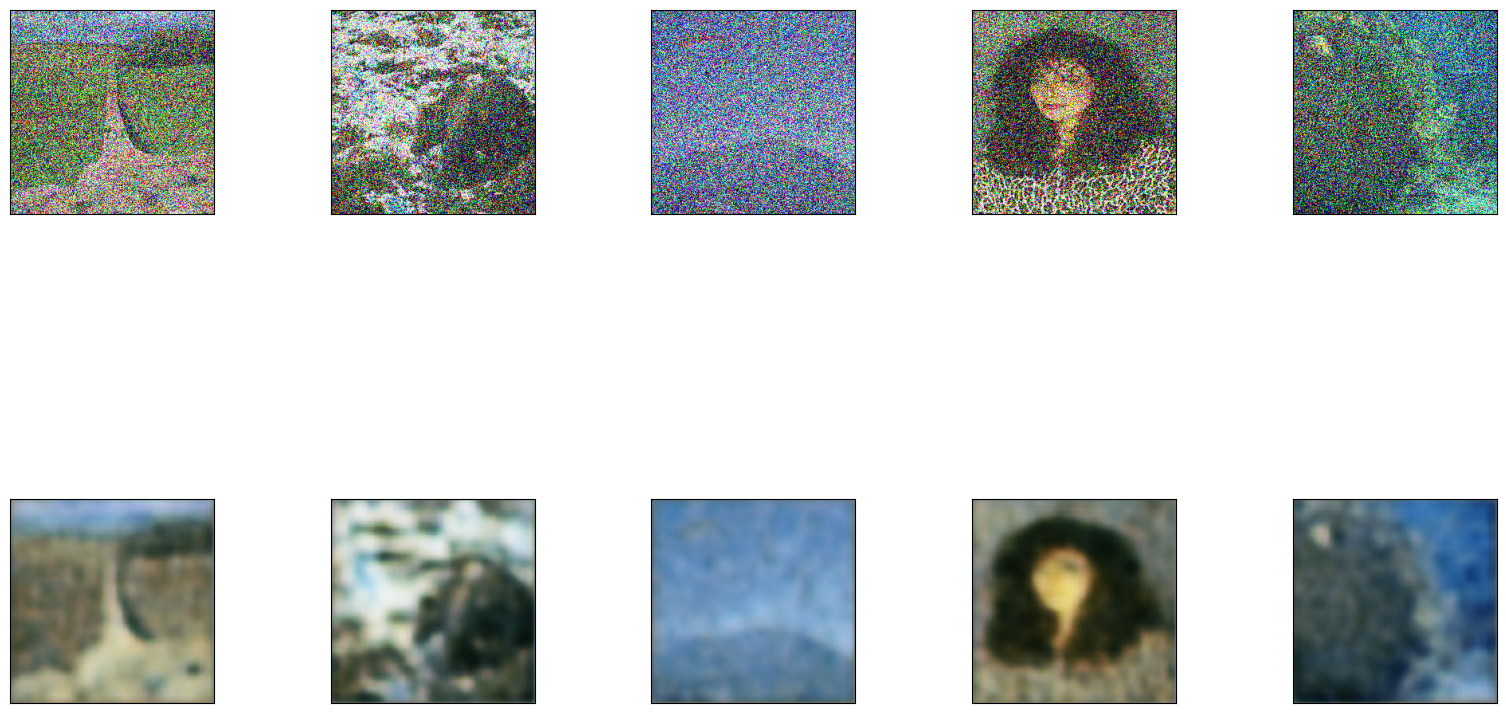

(200, 32, 32, 128)

In [41]:
cnn_code_latten=cnn_encoder_model.predict(x_train_noised)
cnn_decoded=cnn_decoder_model(cnn_code_latten)
# plot_images(x_train_noised ,cnn_decoded)
# cnn_decoded
plot_images_from_not_np_array(x_train_noised,cnn_decoded)
cnn_code_latten.shape

7/7 [==============================] - 0s 9ms/step


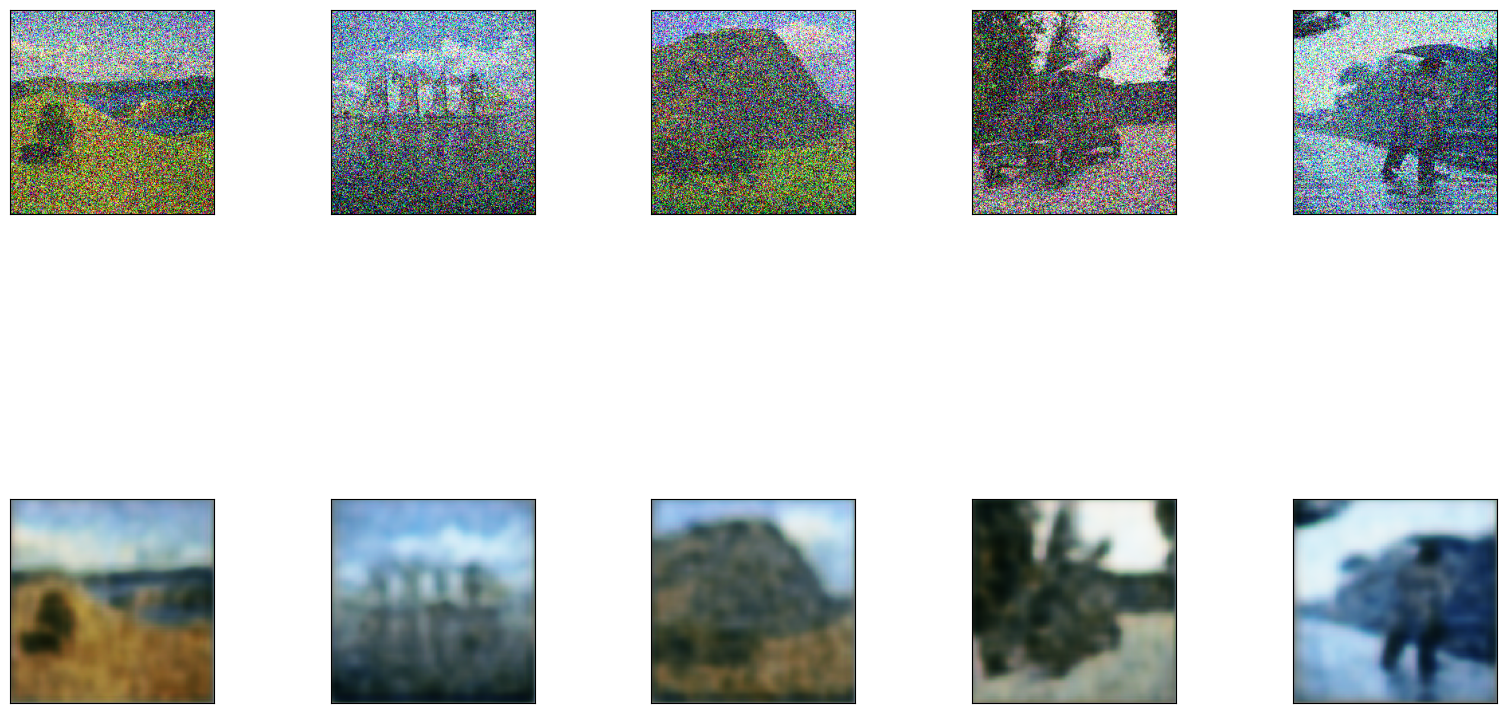

(200, 32, 32, 128)

In [42]:
cnn_code_latten=cnn_encoder_model.predict(x_test_noised)
cnn_test_decoded=cnn_decoder_model(cnn_code_latten)
# plot_images(x_train_noised ,cnn_decoded)
# cnn_decoded
plot_images_from_not_np_array(x_test_noised,cnn_test_decoded)
cnn_code_latten.shape

In [ ]:
def plot_pairs_of_mages_images(noised_images, decoded_images):
    n = 10  # How many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(noised_images[i].reshape(256, 256, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_images[i].numpy().reshape(256, 256, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


In [ ]:
plot_pairs_of_mages_images(x_train_noised,cnn_decoded)